# A program to model the detergent corona around a membrane protein

**Student:** Helena de Castro Alvarenga <br>
**Supervisor/Instructor:** Dr. Khanh Dao Duc <br>
**Contributor:** Dr. Frédéric Poitevin

<p style='margin-right:10%;text-align: justify;'>
    Membrane proteins play important roles in the cell, such as signaling and transporting. Due to their intrinsic hydrophobic nature, these molecules have the tendency to aggregate when extracted from the membrane and, therefore, are hard to express, purify and crystallize. Those characteristics result in structure characterization limitations that manifests in underrepresentation of those proteins in structural databases. As of April 2022, Membrane and cell surface proteins and peptides combined represent only 1.4% of entries in the Protein Data Bank (PDB) (Berman et al., 2000). The inclusion of a membrane-mimetic detergent/lipid in the solution stabilizes the protein but adds a new factor to consider in structural experiments (Earl et al., 2017).
<br><br>
     For the structural determination of proteins there are different techniques to use. Cryo-EM is an approach that has been rapidly advancing (Renaud et al., 2018) despite being decades younger than X-ray Crystallography, the dominating technique in the field. In 2021, Electron Microscopy-determined structures constituted approximately 23.4% of PDB data (Berman et al., 2000). It requires less sample and less purity in comparison to other techniques (Bai et al., 2015).  
<br><br>
     Inspired by MemProt, a program that models a detergent corona around a membrane protein from SAXS data (Pérez & Koutsioubas, 2015; Berthaud et al., 2012), a similar model hereby constructed can provide a PDB file that can be used in Cryo-EM simulations. Therefore, it will be possible to compare the model to experimental data and hopefully that will permit a better understanding of the influence of the detergent on Cryo-EM data.
</p>


***
## Setup

### Libraries
Matplotlib<br>
Numpy<br>
Gemmi<br>
Scikit-learn<br>
Scipy<br>

### Files
pdb/aquaporin.pdb<br>
generate_corona.py<br>
atomic_models.py<br>
<br>
<br>

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import gemmi
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

import generate_corona as gc
import atomic_models as am

%matplotlib notebook

In [2]:
#Preset parameters for ploting
def set_params():
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.set_zlim(-60, 60)

file_path = "pdb/aquaporin.pdb"

***
## Importing the membrane protein

<p style='text-align: justify;margin-right:10%;'>
Throughout this notebook, we will be using the Aquaporin complex as an example of membrane protein [pdb/aquaporin.pdb], monomer [2b6p] downloaded from the Protein Data Bank (PDB).
</p>

### Extracting the coordinates from a PDB

<IPython.core.display.Javascript object>


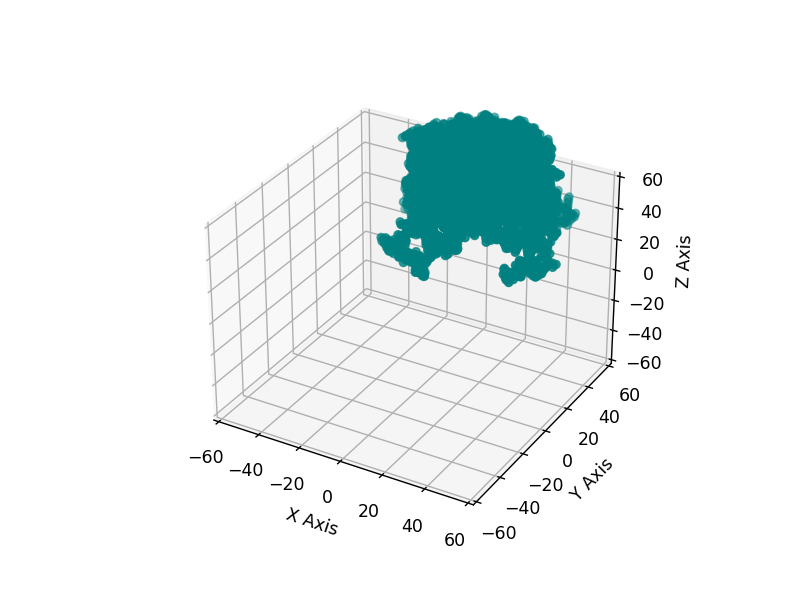

In [3]:
#Getting the XYZ coordinates of the atoms of the Aquaporin complex
#as arrays [X1,...,Xi,...,Xn],[Y1,...,Yi,...,Yn],[Z1,...,Zi,...,Zn]
#pX,pY,pZ = protein coordinates
pX,pY,pZ = gc.getProtein(file_path) 

#Ploting the coordinates
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pX,pY,pZ, color = 'teal')
set_params()
plt.show()

### Centering and rotating the structure
<p style='text-align: justify;margin-right:10%;'>
Using Principal Component Analysis (PCA), a method for data decomposition, we can extract the main axis where our data is distributed. A matrix transformation is a function that represents a modification on our dataset. In this case, the transformation is aligning the principal component of the coordinate points to the Z-axis. Therefore, we can distribute the atoms on another axis and, by doing so, rotate the protein so that its transmembrane portion is positioned properly in space.
</p>

<IPython.core.display.Javascript object>


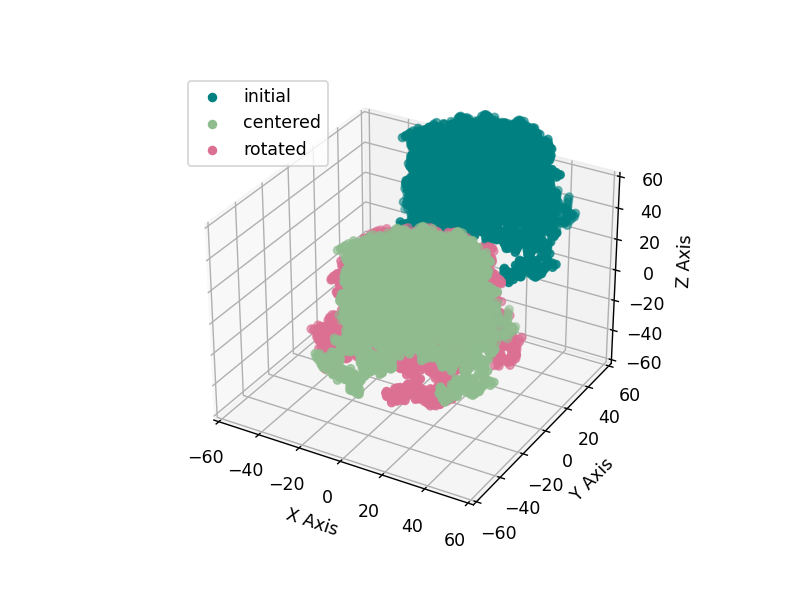

In [9]:
#cX,cY,cZ = centralized protein coordinates
cX = gc.centerProtein(pX)
cY = gc.centerProtein(pY)
cZ = gc.centerProtein(pZ)

#cXYZ = coordinates formated to ([X1,Y1,Z1],...[Xi,Yi,Zi],..., [Xn,Yn,Zn])
cXYZ = gc.format_coord(cX,cY,cZ)

#Using sklearn library to get a Principal Component Analysis (PCA) of the coordinates data
pca = PCA(n_components=3)
pca.fit(cXYZ)

vec = pca.components_[0]
Zaxis = [1,0,0]

mat = gc.rotation_matrix_from_vectors(vec, Zaxis)

#rX,rY,rZ = rotated protein coordinates (aligned with Z axis)
rX = []
rY = []
rZ = []
for item in cXYZ:
    vec_rot = mat.dot(item)
    rX.append(vec_rot[0])
    rY.append(vec_rot[1])
    rZ.append(vec_rot[2])
    
#Ploting the rotated protein
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pX,pY,pZ, color = 'teal', label = 'initial')
ax.scatter(cX,cY,cZ, color = 'darkseagreen', label = 'centered')
ax.scatter(rX,rY,rZ, color = 'palevioletred', label = 'rotated')
set_params()
ax.legend()
plt.show()

***
## Creating a corona around the protein

<p style='text-align: justify;'>
To create the Ellipsoid we will compute the points that satisfy the condition:</p><br>
$\frac{x^{2}}{a^{2}} + \frac{y^{2}}{b^{2}} + \frac{z^{2}}{c^{2}} >= 1$

![title](results/ellipsoid.png)

<p style='text-align: justify;'>
Origin &rarr; $O = (O_{x},O_{y},O_{z})$ <br>

X-axis extreme points: <br>
&rarr; $A_{1} = (O_{x}-a,O_{y},O_{z})$ <br>
&rarr; $A_{2} = (O_{x}+a,O_{y},O_{z})$ <br><br>
Y-axis extreme points: <br>
&rarr; $B_{1} = (O_{x},O_{y}+b,O_{z})$ <br>
&rarr; $B_{2} = (O_{x},O_{y}-b,O_{z})$ <br><br>
Z-axis extreme points: <br>
&rarr; $C_{1} = (O_{x},O_{y},O_{z}+c)$ <br>
&rarr; $C_{2} = (O_{x},O_{y},O_{z}-c)$ <br><br>

The equation of the Ellipsoid:

$\frac{(x-Ox)^{2}}{a^{2}} + \frac{(y-Oy)^{2}}{b^{2}} + \frac{(z-Oz)^{2}}{c^{2}} = 1$
<br>

Consider $O = (0,0,0)$, as the protein was<br> 
centered after the coordinates were imported
</p>

<p style='margin-right:10%;text-align: justify;'>
The method used in this program creates an ellipsoid by generating points iteratively in regular intervals dependent on the ray of the pseudoatom. After that, a function removes the coordinates in the most inner part of the ellipsoid that would conflict with the protein's atoms. This process' speed depends on the number of pseudo atoms, that itself depends on the parameters of the corona such as the height, determined by size of the transmembrane portion of the protein, and on the ray of the pseudo atoms filling the ellipsoid.
</p>

### Generating the detergent corona

<p style='text-align: justify;margin-right:10%;'>
Creating the hydrophobic interior ellipsoid of the corona with the following parameters:</br>
a &rarr; 58Å</br>
b &rarr; 58Å</br>
c &rarr; 17Å</br>
pseudo atom type &rarr; CA</br>
pseudo atom ray &rarr; 1.5</br>

And the hydrophilic shell:</br>
a &rarr; 65Å</br>
b &rarr; 65Å</br>
c &rarr; 20Å</br>
pseudo atom type &rarr; N</br>
pseudo atom ray &rarr; 1.5</br>

These measures were chosen empirically for a better visualization of the exemple on Pymol
</p>

In [5]:
#Generating the hydrophobic interior ellipsoid of the corona
iX,iY,iZ = gc.generateEllipsoid(1.5,58,58,17)   #iXYZ = coordinates of the corona interior

#Generating the hydrophilic exterior ellipsoid of the corona
sX,sY,sZ = gc.generateEllipsoid(1.5,65,65,20)   #sXYZ = coordinates of the corona shell  

### Excluding the overlaping pseudoatoms

<p style='text-align: justify;margin-right:10%;'>
Now that we have our two ellipsoids we need to delete from our corona the pseudo atoms that are physically overlapping with other atoms</br>
Observation: the next steps take a couple of minutes to run
</p>

In [6]:
#Defining the components of the model
interior = gc.format_coord(iX,iY,iZ)
protein = gc.format_coord(rX,rY,rZ)
shell = gc.format_coord(sX,sY,sZ)

In [7]:
#Removing the atoms of the interior of the ellipsoid 
#that overlap with the protein's atoms
to_remove_1 = list()
for pt in interior:
    if gc.in_hull(protein,pt):
        to_remove_1.append(pt)

for pt in to_remove_1:        
    interior.remove(pt)

In [8]:
#Removing the atoms of the interior of the ellipsoid that 
#overlap with the atoms of the protein and hydrophobic core
to_remove_2 = list()
for pt in shell:
    if gc.in_hull(interior,pt):
        to_remove_2.append(pt)
    elif gc.in_hull(protein,pt):
        to_remove_2.append(pt)

for pt in to_remove_2:        
    shell.remove(pt)

***
## Generating the final PDB file

In [9]:
#generate a PDB file with the corona coordinates
am.clean_gemmi_structure(structure=None)
am.write_atomic_model("pdb/model.pdb", model=gemmi.Model("model"))
pseudoatom1 = len(interior)*["N"]
pseudoatom2 = len(shell)*["CA"]
prtn_atoms = gc.getData(file_path)
am.write_cartesian_coordinates(
    "pdb/model.pdb",
    (("A",pseudoatom1,interior),
     ("B",pseudoatom2,shell),
     ("C",prtn_atoms,protein))
)

## Results

### Pymol visualization

<p style='text-align: justify;margin-right:10%;'>
The model is shown represented by spheres, with the protein colored by atom type and the corona colored by chain (hydrophilic portion in teal and hydrophobic core in yellow).
</p>

![title](results/image1.1.png)

![title](results/image2.1.png)

![title](results/image3.1.png)

![title](results/image4.1.png)

***
## TEM Simulator

<p style='margin-right:10%;text-align: justify;'>
    The simulation of Cryo-EM experiments will be done using a wrapper from simSPI, a repository of methods and tools for simulating Single Particle Image data. The TEM Dataset Generation is done by configuring the necessary files and parameters and calling TEM Simulator to generate the Cryo-EM images. <br><br>    
    For that, the program requires a couple of .yaml files (path_config.yaml, with the metadata and pdb file path, and sim_config.yaml, that describes the experimental parameters). The parameters used will be decided on the average parameters used in the field, to provide images as consistent with experimental data as possible, including the existence of noise.
</p>

***
# References

<p style='margin-right:10%;text-align: justify;'>
Bai, X. C., McMullan, G., & Scheres, S. H. (2015). How cryo-EM is revolutionizing structural biology. Trends in Biochemical Sciences, 40(1), 49–57. https://doi.org/10.1016/j.tibs.2014.10.005 <br><br>
Berman, H. M., Westbrook, J., Feng, Z., Gilliland, G., Bhat, T. N., Weissig, W., Shindyalov, I. N., & Bourne, P. E. (2000). RCSB PDB: Statistics. The Protein Data Bank. Retrieved April 29, 2022, from https://www.rcsb.org/stats <br><br>
Berthaud, A., Manzi, J., Pérez, J., & Mangenot, S. (2012). Modeling Detergent Organization around Aquaporin-0 Using Small-Angle X-ray Scattering. Journal of the American Chemical Society, 134(24), 10080–10088. https://doi.org/10.1021/ja301667n <br><br>
Earl, L. A., Falconieri, V., Milne, J. L., & Subramaniam, S. (2017). Cryo-EM: beyond the microscope. Current Opinion in Structural Biology, 46, 71–78. https://doi.org/10.1016/j.sbi.2017.06.002 <br><br>
Pérez, J., & Koutsioubas, A. (2015). Memprot: a program to model the detergent corona around a membrane protein based on SEC–SAXS data. Acta Crystallographica Section D Biological Crystallography, 71(1), 86–93. https://doi.org/10.1107/s1399004714016678 <br><br>
Renaud, J. P., Chari, A., Ciferri, C., Liu, W. T., Rémigy, H. W., Stark, H., & Wiesmann, C. (2018). Cryo-EM in drug discovery: achievements, limitations and prospects. Nature Reviews Drug Discovery, 17(7), 471–492. https://doi.org/10.1038/nrd.2018.77 <br><br>
</p>